# Predicting Monetary Policy Changes using NLP

## Step 3: analysis of statement sentiment by lexicon

Goals of this notebook:
+ Create and improve specific dictionaries
+ Build a sentiment indicator of monetary policy
+ Asses if there is a relationship between economy and net sentiment

In [34]:
# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
import datetime as dt
from functools import reduce


# Import NLP modules
import re
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import spacy
from tqdm.notebook import tqdm

#data_path = 'C:\\Users\\vilis\\Master DSDM\\Term 2\\Introduction of Text Mining and Natural Language Processing\\Final project'
data_path = '/home/vl/win/Term 2/Introduction of Text Mining and Natural Language Processing/Final project/Final presentation/Data'
#data_path = 'C:\\Users\\vilis\\Master DSDM\\Term 2\\Introduction of Text Mining and Natural Language Processing\\Final project\\Final presentation\\Data'

[nltk_data] Downloading package stopwords to /home/vl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Explore the text

In [35]:
df_text_chile = pd.read_csv(data_path + '/text_data_chile.csv')
# Dictionary tone assessment will compare them by Index (need the numbers back) 
df_text_chile['Index'] = range(0, len(df_text_chile))
print(df_text_chile.shape)
df_text_chile.head()


(277, 4)


,statement,date,text,Index
0,rpm_26_enero_2023.pdf,1/26/2023,Comunicado de Prensa Jueves 26 de enero de ...,0
1,rpm_6_diciembre_2022.pdf,12/6/2022,Comunicado de Prensa Martes 6 de diciembre ...,1
2,rpm_12_octubre_2022.pdf,10/12/2022,Comunicado de Prensa Miércoles 12 de octubr...,2
3,rpm_06_septiembre_2022.pdf,9/6/2022,Comunicado de Prensa Martes 6 de septiembre...,3
4,comunicado-rpm-13072022.pdf,7/13/2022,Comunicado de Prensa Miércoles 13 de julio ...,4


In [36]:
nlp = spacy.load('es_core_news_sm', exclude=["ner"])
stop = list(nlp.Defaults.stop_words)

# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [37]:
corpus_chi = create_corpus(df_text_chile)
x, y = get_frequent_stop_words(corpus_chi)
w, z = get_frequent_nonstop_words(corpus_chi)

print('-----------------------')
print('Chile')
print('Frequent stopwords: \n')
print(x)
print(y)
print('-----------------------')
print('Non-Frequent stopwords: \n')
print(w)
print(z)


-----------------------
Chile
Frequent stopwords: 

('de', 'la', 'en', 'el', 'las', 'los', 'del', 'se', 'que', 'con')
(9197, 4806, 3557, 3066, 2137, 1907, 1879, 1827, 1620, 915)
-----------------------
Non-Frequent stopwords: 

('y', 'a', 'política', 'inflación', 'n', 'monetaria', 'l', 'consejo', 'tasa', 'interés')
(1986, 1624, 1221, 1028, 855, 799, 593, 586, 442, 414)


[Text(0.5, 0, 'Number of repetitions'),
 Text(0, 0.5, 'Word'),
 Text(0.5, 1.0, 'Most frecuent non stopwords - Chile')]

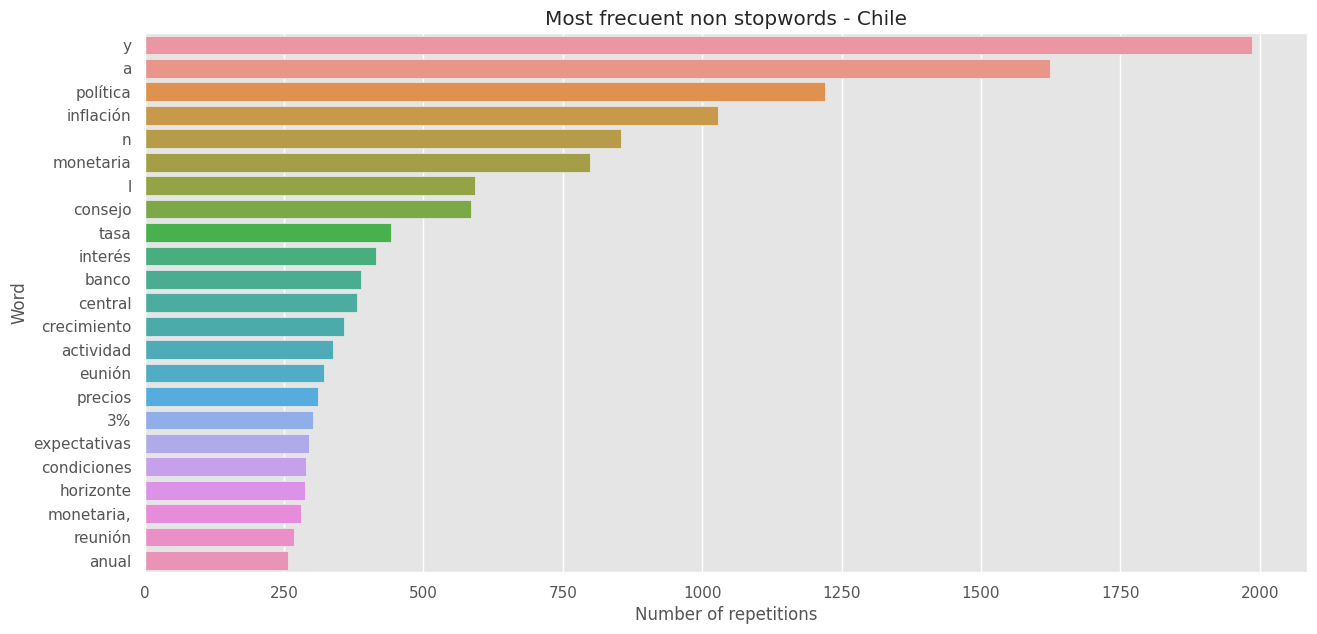

In [38]:
# Check most frequent words which are not in stopwords
def most_frequent_words(corpus):
    counter = Counter(corpus)
    most = counter.most_common()[:45]
    x, y = [], []
    for word, count in most:
        if word not in stop:
            x.append(word)
            y.append(count)
    return (x,y)


plt.figure(figsize=(15,7))
x, y = most_frequent_words(corpus_chi)
ax = sns.barplot(x = y, y = x)
ax.set(xlabel='Number of repetitions', ylabel='Word', title='Most frecuent non stopwords - Chile')
#plt.show()





## Approach 1: sentiment based on Loughran and McDonald dictionary

In [39]:
# Load sentiment data
sentiment_spanish = pd.read_csv(data_path + '/spanish_dictionary.csv')
sentiment_spanish['sentiment'].value_counts()

negative    1525
positive     335
Name: sentiment, dtype: int64

In [40]:
# Create a dictionary
sentiments = sentiment_spanish['sentiment'].unique()
sentiment_dict = { sentiment: sentiment_spanish.loc[sentiment_spanish['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

#### Analyze the tone with negation without lemmatization

In [41]:
# Consider Negation
negate_es = ["no pudo", "no se pudo", "no es", "no podría", "no debe","ninguno", "no", "no podrá", "no debería", "no necesita", 
           "nunca", "ninguno", "ni", "nada", "no necesitaría", "no fue", "no era", "sin", "no lo haría", "no habría",
           "no lo hará", "rara vez", "a pesar de", "nadie", "no se habría"]

negate_en = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate_es:
        return True
    else:
        return False
    
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0
    net_sent = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
        net_sent = pos_count - neg_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, net_sent, pos_words, neg_words]
 
    return results

columns = ['tone_LM', 'word_count', 'n_pos_words', 'n_neg_words', 'net_sent', 'pos_words', 'neg_words']

In [42]:
# Analyze tone for original text dataframe
from tqdm import tqdm, notebook


def tone_original_text(df_text):
    tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(df_text['text'], total=df_text.shape[0])]
    tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
    tone_lmdict_df['Index'] = range(0, len(tone_lmdict_df))
    df_approach1 = pd.merge(df_text, tone_lmdict_df, on='Index')
    df_approach1['date'] = pd.to_datetime(df_approach1['date'])
    df_approach1.sort_values(by='date', ascending = True, inplace = True)
    df_approach1.set_index('date', inplace=True)
    return(df_approach1)

df_approach1_chile = tone_original_text(df_text_chile)


100%|██████████| 277/277 [00:00<00:00, 326.88it/s]


/tmp/ipykernel_22765/4168625354.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


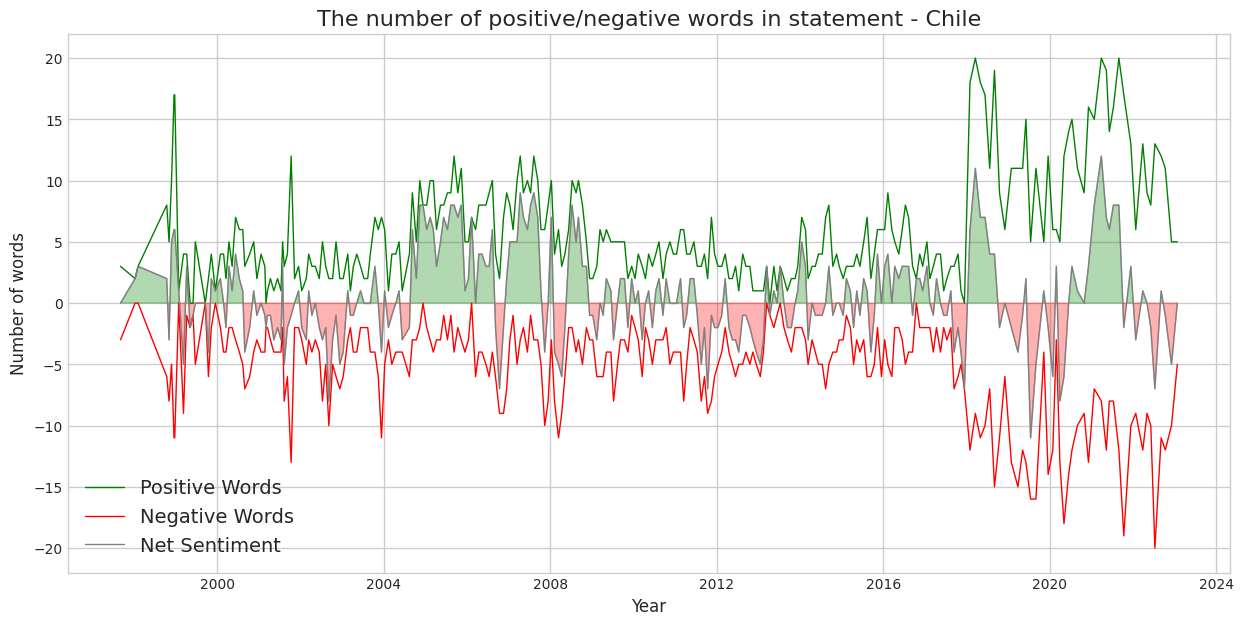

In [43]:

def plot_pos_neg_word(df_approach1,country):
    plt.style.use('seaborn-whitegrid')

    fig, ax = plt.subplots(figsize=(15, 7))


    ax.plot(df_approach1.index, df_approach1['n_pos_words'], c='green', linewidth= 1.0)
    ax.plot(df_approach1.index, df_approach1['n_neg_words']*-1, c='red', linewidth=1.0)
    ax.plot(df_approach1.index, df_approach1['net_sent'], c='grey', linewidth=1.0)

    ax.set_title('The number of positive/negative words in statement - ' + country, fontsize=16)
    ax.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=0)
    #ax.tick_params(axis='both', which='minor', labelsize=6)
    ax.set_xlabel('Year',fontsize=12)
    ax.set_ylabel('Number of words',fontsize=12)
    #plt.xlabel('xlabel', fontsize=18)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.fill_between(df_approach1.index, df_approach1['net_sent'], where=(df_approach1['net_sent'] > 0), color='green', alpha=0.3, interpolate=True)
    ax.fill_between(df_approach1.index, df_approach1['net_sent'], where=(df_approach1['net_sent'] <= 0), color='red', alpha=0.3, interpolate=True)
   
    import matplotlib.dates as mdates
    ax.half_year_locator = mdates.MonthLocator(interval=6)  # every month
    ax.year_formatter = mdates.DateFormatter('%Y')

    #plt.xticks(np.arange(0,len(df_approach1.text),12), rotation = 'vertical')
    ax.grid(True)
    return(fig,ax)

#plot_peru = tone_original_text(df_approach1_peru)
sns.set(font_scale=2)
fig, ax = plot_pos_neg_word(df_approach1_chile,'Chile')



Positive and negative word counts highly correlated probably because of the total number of words varies. Take the positive - negative as Net Sentiment.

#### Original

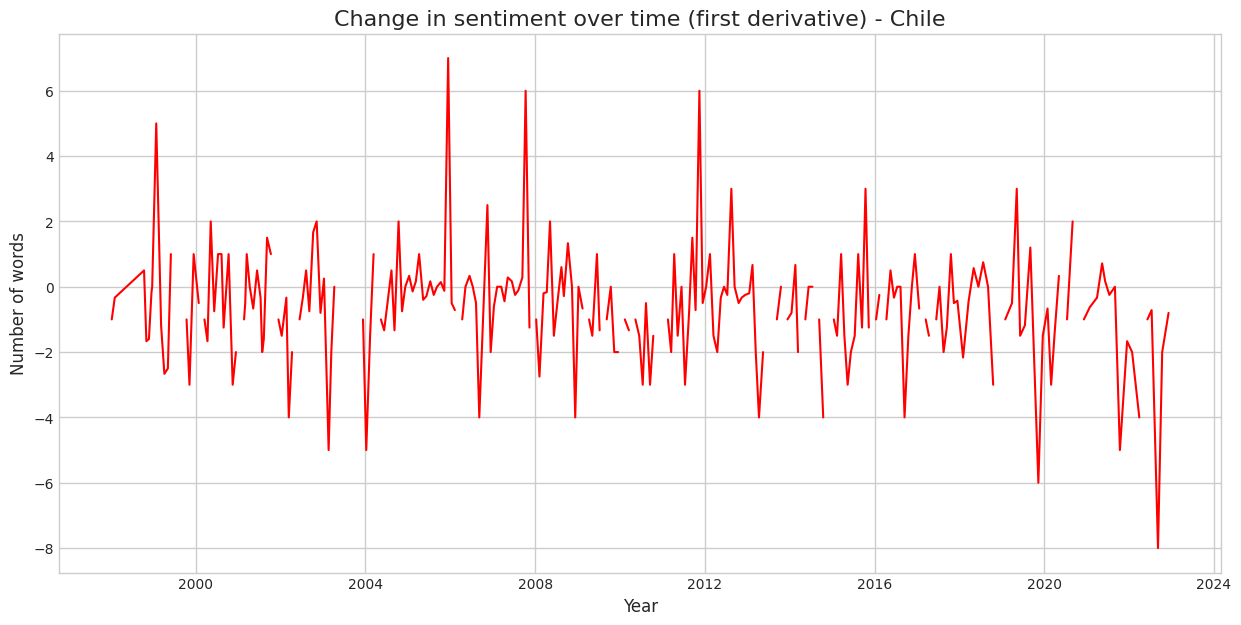

In [44]:
def sentiment_change(df_approach1,country):
    firstderivative = (df_approach1['net_sent'].shift(1) - df_approach1['net_sent']) / df_approach1['net_sent']

    fig, ax = plt.subplots(figsize=(15,7))

    ax.plot(df_approach1.index, firstderivative, c = 'red')
    ax.set_title('Change in sentiment over time (first derivative) - ' + country, fontsize=16)
    ax.set_xlabel('Year',fontsize=12)
    ax.set_ylabel('Number of words',fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    return(fig,ax)
# format the ticks
# round to nearest years
    #plt.show()

fig, ax = sentiment_change(df_approach1_chile,'Chile')

#### Proposition


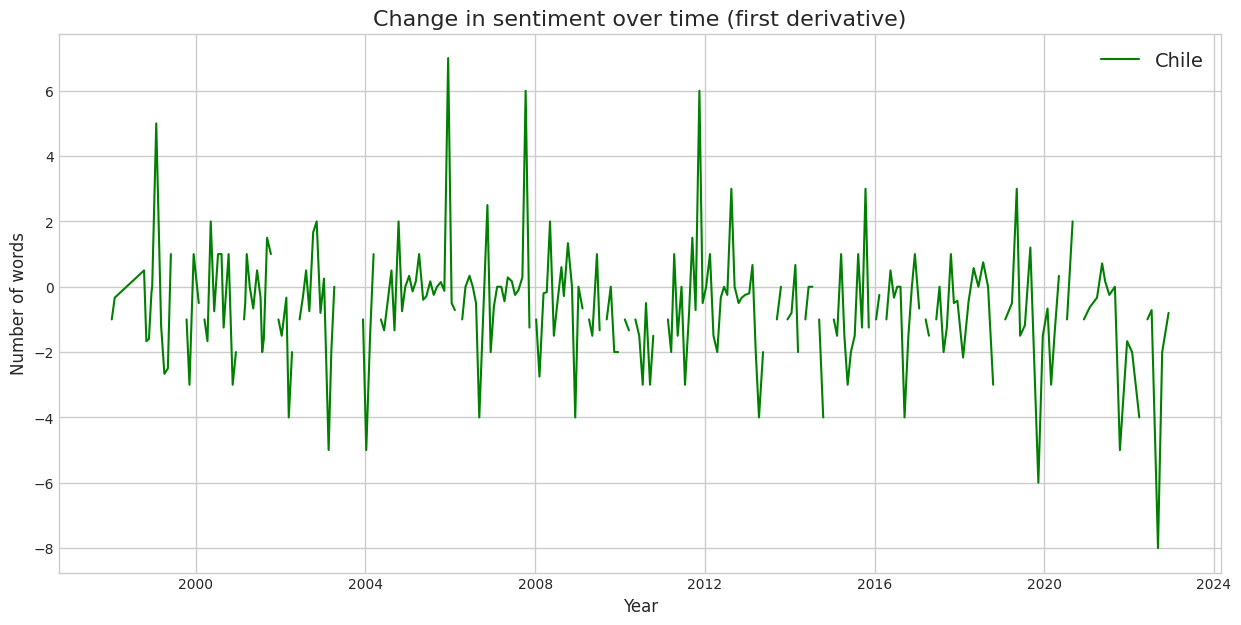

In [45]:
def sentiment_change(df_approach1_chile):

    firstderivative_chi = (df_approach1_chile['net_sent'].shift(1) - df_approach1_chile['net_sent']) / df_approach1_chile['net_sent']
    fig, ax = plt.subplots(figsize=(15,7))

    #ax.plot(df_approach1_per.index, firstderivative, c = 'red')
    ax.plot(df_approach1_chile.index, firstderivative_chi, c = 'green')
    ax.set_title('Change in sentiment over time (first derivative)', fontsize=16)
    ax.set_xlabel('Year',fontsize=12)
    ax.set_ylabel('Number of words',fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend([ 'Chile'], prop={'size': 14}, loc=0)
    return(fig,ax)
# format the ticks
# round to nearest years
    #plt.show()

fig, ax = sentiment_change(df_approach1_chile)
#fig, ax = sentiment_change(df_approach1_chile,'Chile')

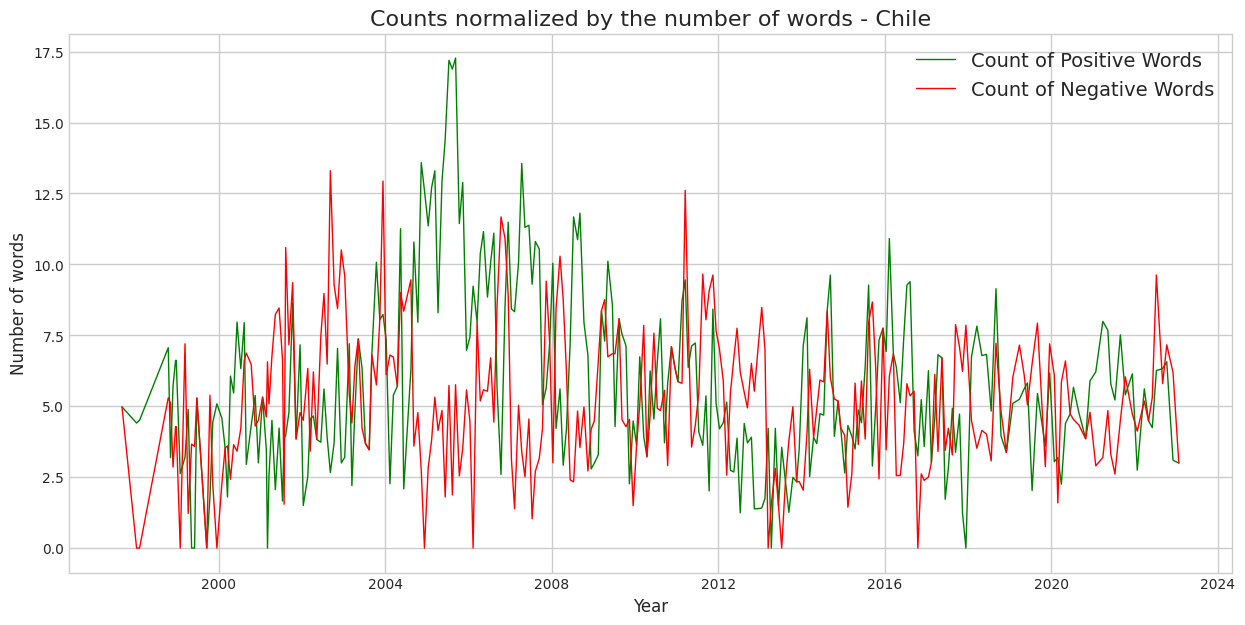

In [46]:
# Normalize data
def normalize_count(df_approach1, country):
    NPositiveWordsNorm = df_approach1['n_pos_words'] / df_approach1['word_count'] * np.mean(df_approach1['word_count'])
    NNegativeWordsNorm = df_approach1['n_neg_words'] / df_approach1['word_count'] * np.mean(df_approach1['word_count'])
    NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(df_approach1.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
    ax.plot(df_approach1.index, NNegativeWordsNorm, c='red', linewidth=1.0)

    ax.set_title('Counts normalized by the number of words - ' + country, fontsize=16)
    ax.legend(['Count of Positive Words', 'Count of Negative Words'],
            prop={'size': 14},
            loc = 0
            )
    ax.set_xlabel('Year',fontsize=12)
    ax.set_ylabel('Number of words',fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    return(fig,ax)

#fig, ax = normalize_count(df_approach1_peru,'Peru')
fig, ax = normalize_count(df_approach1_chile,'Chile')

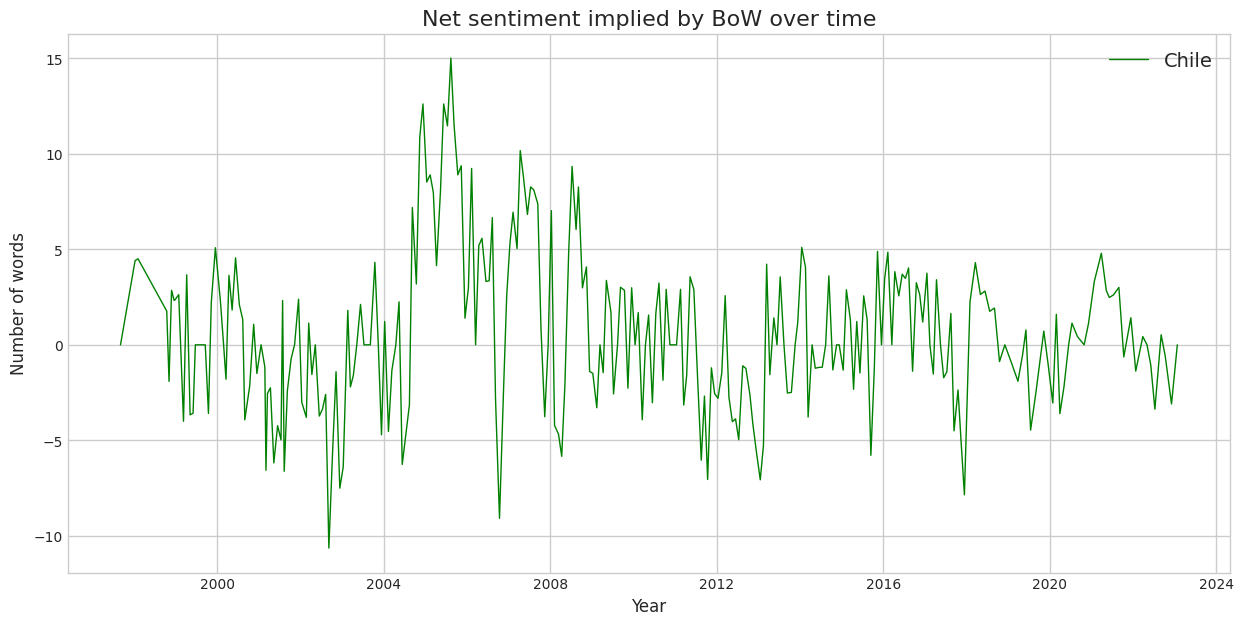

In [47]:
def net_sentiment_nom(df_approach1):
    NPositiveWordsNorm = df_approach1['n_pos_words'] / df_approach1['word_count'] * np.mean(df_approach1['word_count'])
    NNegativeWordsNorm = df_approach1['n_neg_words'] / df_approach1['word_count'] * np.mean(df_approach1['word_count'])
    NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)
    return(NetSentimentNorm)


def net_sentiment_bow(df_approach1_chile):
    
    fig, ax = plt.subplots(figsize=(15,7))
    #ax.plot(df_approach1_per.index, net_sentiment_nom(df_approach1_per), c='red', linewidth=1.0)
    ax.plot(df_approach1_chile.index, net_sentiment_nom(df_approach1_chile), c='green', linewidth=1.0)
    ax.set_xlabel('Year',fontsize=12)
    ax.set_ylabel('Number of words',fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title('Net sentiment implied by BoW over time',size = 16)
    ax.legend(['Chile'],
            prop={'size': 14},
            loc = 1
            )
    return(fig, ax)

fig,ax = net_sentiment_bow(df_approach1_chile)


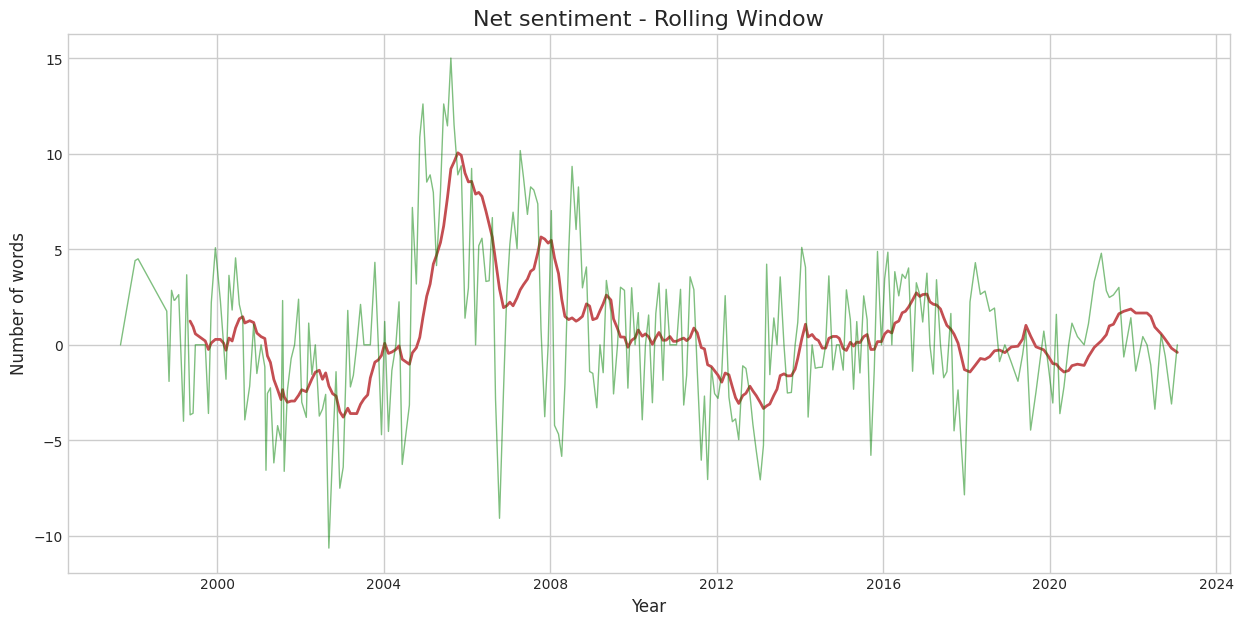

In [48]:
Window = 12
def missing_name(df_approach1):
    NetSentimentNorm =net_sentiment_nom(df_approach1)
    CompToMA = NetSentimentNorm.rolling(Window).mean()

    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(df_approach1.index, CompToMA, c = 'r', linewidth= 2)
    ax.plot(df_approach1.index, NetSentimentNorm, c = 'green', linewidth= 1, alpha = 0.5)
    ax.set_xlabel('Year',fontsize=12)
    ax.set_ylabel('Number of words',fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title('Net sentiment - Rolling Window',size = 16)
    return(fig,ax)
 

#fig,ax = missing_name(df_approach1_peru)
fig,ax = missing_name(df_approach1_chile)


## Approach 2: sentence evaluation (Gonzalez and Tadle, 2021)

In [49]:
hawkish = ['crédito', 'dólar', 'doméstica', 'domestico', 'moneda nacional', 'demanda', 'actividad económica', 
             'sistema financiero', 'producto alimenticio', 'moneda extranjera', 'divisas', 'economía global', 
             'crecimiento', 'inflación', 'determinante de la inflación', 'pronóstico de inflación', 'financiero internacional', 
             'mercado', 'precio', 'precios', 'recuperación', 'choque de oferta', 'choques de oferta']

#dovish = ['presiones', 'riesgo', 'desaceleración', 'déficit', 'incertidumbre', 'incierto']
dovish = []


positive = ['arriba','acelerar','acelerado', 'acelerada', 'acelera','aceleran','acelerando','acomodar','acomodado','acomoda','acomodando','agregado',
 'aumentar','aumentado','aumentada','aumenta','benigno','mejor','mejores','mejoras','mejoró','grande','impulsar','impulsado','impulsó',
 'brillante','calma','calmado','calmante','calmar','calmó','escala','escalar','escaló','escalando','depreciar','depreciado','deprecia','depreciándose',
 'depreciada', 'dinámica','elevar','elevado','elevados','elevada','eleva','elevan','elevando','elevándose','alentando','escalamiento','escalado','escala',
 'exceder','excedió','exceden','excede', 'excediendo','expande','expandió','expandir','expandiendo','expandido','expandida','expansivo','expansiva','rápido',
 'rápidamente','rapidez','favorable','favorablemente', 'favorece','favoreciendo','favoreció','firme','firmemente','bueno','bien', 'excelente','grande','mayor',
 'mayores','creció','crece','creciendo','crecerá','crecido','saludable','alto','mejorar','mejorado','mejora','mejorando','impulso','impulsado','impulsos','impulsando',
 'aumento','aumentó','aumentar','aumenta','aumentando','inflacionario','grande', 'largo','levantar','levantado',
 'levantando','levanta','suelto','ligero','ligeramente','ligera','máximo','máximos','máxima','máximas','mitigar','mitigado',
 'mitiga','mitigando','más','monto','optimista','supera','superar','superó','superando','pico','picos','positivo','incrementar','incrementó','incrementa',
 'incrementando','incrementos','levantado','levanta','levantando','rampa','rampado','rampante','rampas','rápido','recuperar','recuperado','recuperando','recupera',
 'reforzar','reforzado','refuerza','reforzando','restaurar','restaurado','restaura','alza','alzas','levantado','levanta',
 'levantando','satisfactorio','disparar','disparado','disparándose','disparos','estabilizar','estabiliza','estabilizado','estabilizando','estable','estabilizó',
 'estimula','estimulado','estimulante','estimulación','estimulando','estimulador','fortalece','fortalecer','fortaleció','fortaleciendo','fuerte','fortalecimiento',
 'exitoso','rápido','superior','volcado','repuntes', 'repuntando','vigoroso','ampliar','ancho','ensanchando','ensancha','amplio']

negative = ['adverso','agravar','agravado','agrava','agravando','agravante','apreciar','apreciado','aprecia','apreciando','apreciatorio','malo',
 'preocupación','preocupado','relativo','preocupaciones','conservador','restringir','restringido','restringiendo','restringe','contrato',
 'contraído','contrayendo','contractivo','contrae','corta','corta','corta','amortigua','amortigua','amortigua','amortigua','desacelera','desacelera',
 'desacelera','desacelera','deprimido','deprime','deprimida','disminuye','disminuyó','disminuyendo','disminuiría','disminuirá','disminución',
 'profundiza','profundo','profunda','profundizado','profundizando','profundiza','deflacionario','descender','descendiendo','desciende','descendió',
 'descendente','desestabilizar','desestabilizante','desestabilizador','desestable','desestabilizó','deteriorar','deteriorado','deteriora','deterioro',
 'deteriorando','deteriorada','difícil','disminuir','disminuido','disminuye','disminuyendo','disminución','decepcionante','desinflacionario','dovish','reducción','abajo',
 'abajo','soltar','caer','cayó','caería','cayendo','erosionar','erosionando','erosionar','erosionar','desvanecerse','deterioro', 'deterioró',
 'desvanecerse','falla','fallar','falló','fallando','caer','caído','cayendo','caídas','cayó','menos','aplanar','aplanar',
 'aplanar','aplanar','fluctuar','fluctuado','fluctúa','fluctuante','frágil','daño','dañado','dañando','daña','inconsistente','peligro',
 'peligroso','peligrosa','peligrosos','peligrosas ','peligrosamente','mediocre','menos','menor','bajo','rebajada','rebajado',
 'rebajando','baja','suave','mínimo','mínimos','mínima','mínimas','menores','moderado','moderada','moderados','moderadamente','modera','moderando',
 'moderar','moderarse','modesto','modesta','negativo','pesimista','pobre','recesionario','recesión','recesiva','recortado','recortada',
 'recesivo','reducir ','reducido','reducida','reduce','reduciendo','restrictivo','arriesgado','arriesgado','hundido','hundida','acortar','acortado','acortada','recorte',
 'encoger','encoger','encoge','encogido','encogido','fregadero','hundimiento','lento','lenta','lentos','lentas','lentamente','ralentizado','ralentizada','pequeño',
 'pequeña','ínfimo','pequeños','pequeñas','suavizar','suavizado','suave','suavizando','especular','especuló','especulando','especulativo','especulativa','estresar',
 'estresado','estresando', 'estresada','estresaría','estricto','estrictos','moderado','hundido','hundida','suprimir','suprimido','suprime','suprimiendo','amenazar',
 'amenazado ','amenazante','amenaza','apretar ','apretado','apretando','apretando','más apretado','más duro','turbulento','incierto','socavar','desfavorable',
 'desfavorables','desfavoreciendo','inestable','volátil','vulnerable','débil','debilitar','debilitado','debilitando','debilita','débil','peor','empeorar',
 'empeorando','empeoramiento','empeorararía','peor','empeoró','empeore']

In [50]:
# Main dictionary
lmdict = {'hawkish': hawkish, 'dovish':dovish, 'positive': positive, 'negative': negative}

In [51]:
def tone_count_sentence_evaluation(dict, doc):
    tone_score_list = []
    words_count_list = []
    haw_words = []
    dov_words = []
    pos_words = []
    neg_words = []

    sentences = doc.lower().split('.')
    sentences_count = len(sentences)

    for sentence in sentences:
        sentence_score = 0
        haw_count = 0
        dov_count = 0
        pos_count = 0
        neg_count = 0

        input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', sentence.lower())
        words_count = len(input_words)
        words_count_list.append(words_count)

        for i in range(0, words_count):
            if input_words[i] in dict['hawkish']:
                haw_count += 1
                haw_words.append(input_words[i])
            if input_words[i] in dict['dovish']:
                dov_count += 1
                dov_words.append(input_words[i])
            if input_words[i] in dict['positive']:
                pos_count += 1
                pos_words.append(input_words[i])
            if input_words[i] in dict['negative']:
                neg_count += 1
                neg_words.append(input_words[i])

        if (words_count > 0): #and (haw_count != 0 and dov_count != 0):
            if haw_count > dov_count:
                if pos_count > neg_count:
                    sentence_score = 1
                    tone_score_list.append(sentence_score)
                elif pos_count == neg_count:
                    sentence_score = 0
                    tone_score_list.append(sentence_score)
                elif pos_count < neg_count:
                    sentence_score = -1
                    tone_score_list.append(sentence_score)
            elif haw_count == dov_count:
                if pos_count > neg_count:
                    sentence_score = 1
                    tone_score_list.append(sentence_score)
                elif pos_count == neg_count:
                    sentence_score = 0
                    tone_score_list.append(sentence_score)
                elif pos_count < neg_count:
                    sentence_score = -1
                    tone_score_list.append(sentence_score)
            elif haw_count < dov_count:
                if pos_count > neg_count:
                    sentence_score = -1
                    tone_score_list.append(sentence_score)
                elif pos_count == neg_count:
                    sentence_score = 0
                    tone_score_list.append(sentence_score)
                elif pos_count < neg_count:
                    sentence_score = 1
                    tone_score_list.append(sentence_score)
        else:
            sentence_score = 0
            tone_score_list.append(sentence_score)
        
    results = [100*sum(tone_score_list)/sentences_count, sentences_count, sum(words_count_list), haw_words, dov_words, pos_words, neg_words]
    return results

columns = ['tone_GT', 'sentence_count', 'word_count', 'haw_words', 'dov_words', 'pos_modifiers', 'neg_modifiers']

In [52]:
# Analyze tone for original text dataframe
#print(df_text_peru.shape)
def df_approach_2(df_text):
    tone_lmdict = [tone_count_sentence_evaluation(lmdict, x) for x in tqdm(df_text['text'], total=df_text.shape[0])]
    tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
    tone_lmdict_df['Index'] = range(0, len(tone_lmdict_df))
    df_approach2 = pd.merge(df_text, tone_lmdict_df, on='Index')
    return(df_approach2)

#df_approach2_peru = df_approach_2(df_text_peru)
df_approach2_chile = df_approach_2(df_text_chile)


100%|██████████| 277/277 [00:00<00:00, 1041.31it/s]


## Approach 3: tokenization and lemmatization

In [53]:
#!pip install spacy_spanish_lemmatizer

In [54]:
import spacy
import spacy_spanish_lemmatizer
from tqdm import tqdm 

nlp = spacy.load('es_core_news_sm', exclude=["ner"])
nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
stop = list(nlp.Defaults.stop_words)

def spacy_lemmatizer(word):
    token = nlp(word)
    for word in token:
        return word.lemma_

def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='text'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it lower case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words 
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized

def spacy_tokenizer(df, col='text', nlp=nlp):

  docs = nlp.pipe(df[col]) # more efficient, delete lists once processed
  new_stop = ['nota', 'prensa', 'directorio', 'del', 'bcr', 'bcrp','aprobó', 'programa', 'monetario', 'para', 'el', 'mes', 'de',
              'enero','febrero','marzo','abril','mayo','junio','julio','agosto','setiembre','septiembre','octubre','noviembre','diciembre',
              'ciento', 'mes','sesión','lima','informativa','comunicado','jueves','eunión','n','a','o','l','p','a','y','mbas']
  tokenized = []
  #wnl = nltk.stem.WordNetLemmatizer()
  for doc in tqdm(docs, total=len(df[col])):
      # Lemmatize words
      tokens = [token.lemma_ for token in doc]
      # Stop words and alphabetic filter
      tokens = [tok.lower() for tok in tokens if ((tok not in stop) and (tok.isalpha()==1)) and (tok not in new_stop)]
      tokenized.append(tokens)
  return tokenized

#### Tokenize df_text

In [55]:
tokenized_org = spacy_tokenizer(df_text_chile)
print('len(tokenized_org): ', len(tokenized_org))
print(tokenized_org[0])

100%|██████████| 277/277 [01:06<00:00,  4.17it/s]


len(tokenized_org):  277
['política', 'monetaria', 'política', 'monetaria', 'consejo', 'banco', 'central', 'chile', 'acordar', 'mantener', 'tasa', 'interés', 'política', 'decisión', 'adoptada', 'unanimidad', 'miembro', 'inflación', 'mundial', 'disminuir', 'margen', 'asociado', 'menor', 'precio', 'energía', 'obstante', 'inflación', 'persistir', 'nivel', 'elevado', 'presión', 'inflacionarias', 'continuar', 'importante', 'contexto', 'principal', 'banco', 'central', 'continuar', 'subir', 'tasa', 'interés', 'referencia', 'perspectiva', 'crecimiento', 'mantener', 'débil', 'mostrar', 'acotado', 'ajuste', 'alza', 'mercado', 'financiero', 'global', 'reflejar', 'optimismo', 'alimentar', 'cambio', 'política', 'cero', 'covid', 'china', 'perspectiva', 'trayectoria', 'política', 'restrictivo', 'eserva', 'ederal', 'dólar', 'depreciar', 'globalmente', 'apetito', 'riesgo', 'flujo', 'capital', 'economía', 'emergente', 'aumentar', 'mercado', 'bursátil', 'exhibir', 'alzas', 'tasa', 'interés', 'plazo', 'mo

In [56]:
df_text_chile['text'][0]

'Comunicado de Prensa    Jueves 26 de enero de 2023.   eunión de Política Monetaria – enero 2023  n su eunión de Política Monetaria, el Consejo del Banco Central de Chile acordó mantener la tasa de interés de política monetaria en 11,25%. La decisión fue adoptada por la unanimidad de sus miembros.  La inflación mundial ha disminuido en el margen, principalmente asociado a los menores precios de la energía. o obstante, la inflación persiste en niveles elevados y las presiones inflacionarias continúan  siendo  importantes.  n  este  contexto,  los  principales  bancos  centrales  han continuado subiendo sus tasas de interés de referencia. Las perspectivas de crecimiento para 2023 se mantienen débiles, aun cuando muestran un acotado ajuste al alza.  Los  mercados  financieros  globales  han  reflejado  un  mayor  optimismo,  alimentado  por  los cambios  en  la  política  cero  Covid en  China  y  las  perspectivas  de  una  trayectoria  de  política monetaria menos restrictiva por parte 

In [57]:
# Concat the list to create docs
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))
print(lemma_docs_org[0])

len(lemma_docs_org):  277
política monetaria política monetaria consejo banco central chile acordar mantener tasa interés política decisión adoptada unanimidad miembro inflación mundial disminuir margen asociado menor precio energía obstante inflación persistir nivel elevado presión inflacionarias continuar importante contexto principal banco central continuar subir tasa interés referencia perspectiva crecimiento mantener débil mostrar acotado ajuste alza mercado financiero global reflejar optimismo alimentar cambio política cero covid china perspectiva trayectoria política restrictivo eserva ederal dólar depreciar globalmente apetito riesgo flujo capital economía emergente aumentar mercado bursátil exhibir alzas tasa interés plazo mostrar movimiento mixto precio materia prima evolucionar heterogéneo precio cobre aumentar forma importante ubicar libra impulsado mejores perspectiva demanda china petróleo encontrar barril promedio mercado financiero local recoger tendencia global especto

In [58]:
# Create a list of all the words in the dataframe
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])

# Counter object of all the words
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))

# Create a Bag of Word, sorted by the count of words
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])

# Indexing vocabulary, starting from 1.
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}

print("vocab_org['inflación']: ", vocab_org['inflación'])
print("vocab_org['crecimiento']: ", vocab_org['crecimiento'])

len(all_words_org):  44575
política
len(counts_org):  2363
bow_org[:20] ['política', 'inflación', 'mantener', 'tasa', 'consejo', 'anual', 'precio', 'seguir', 'central', 'banco', 'interés', 'economía', 'continuar', 'mercado', 'actividad', 'crecimiento', 'monetaria', 'financiero', 'plazo', 'año']
vocab_org['inflación']:  15
vocab_org['crecimiento']:  36


In [59]:
# Create token id list
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

277


In [60]:
# Add to the dataframe
df_approach3 = df_text_chile.copy(deep=True)
df_approach3['tokenized'] = tokenized_org
df_approach3['token_ids'] = token_ids_org
df_approach3

,statement,date,text,Index,tokenized,token_ids
0,rpm_26_enero_2023.pdf,1/26/2023,Comunicado de Prensa Jueves 26 de enero de ...,0,"[política, monetaria, política, monetaria, con...","[1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 11, 1..."
1,rpm_6_diciembre_2022.pdf,12/6/2022,Comunicado de Prensa Martes 6 de diciembre ...,1,"[martes, política, monetaria, política, moneta...","[178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, ..."
2,rpm_12_octubre_2022.pdf,10/12/2022,Comunicado de Prensa Miércoles 12 de octubr...,2,"[miércoles, política, monetaria, política, mon...","[235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 65, 9, 10, 1,..."
3,rpm_06_septiembre_2022.pdf,9/6/2022,Comunicado de Prensa Martes 6 de septiembre...,3,"[martes, política, monetaria, política, moneta...","[178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1..."
4,comunicado-rpm-13072022.pdf,7/13/2022,Comunicado de Prensa Miércoles 13 de julio ...,4,"[miércoles, política, monetaria, política, mon...","[235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1..."
...,...,...,...,...,...,...
272,bcch_comunicado_094856_es.pdf,11/2/1998,COMUCDO2 de noviembre de 1998Consejo de Banco ...,272,"[banco, central, resolver, reducir, tasa, inst...","[4, 5, 1369, 412, 9, 1516, 247, 247, 2325, 103..."
273,bcch_comunicado_094857_es.pdf,10/13/1998,"antiago, 13 de octubre de 1998COMUCDOConsejo d...",273,"[antiago, banco, central, resolver, reducir, t...","[1751, 4, 5, 1369, 412, 9, 1516, 247, 247, 143..."
274,bcch_comunicado_094858_es.pdf,2/3/1998,"COMUCDOantiago, 3 de febrero de 1998. 1. l ...",274,"[comucdoantiago, consejo, banco, central, reso...","[2350, 3, 4, 5, 1369, 241, 25, 9, 1093, 1, 560..."
275,bcch_comunicado_094859_es.pdf,1/8/1998,"antiago, 8 de enero de 1998. COMUCDO1.2.3.4. ...",275,"[antiago, consejo, banco, central, resolver, a...","[1751, 3, 4, 5, 1369, 685, 1124, 293, 9, 10, 1..."


/tmp/ipykernel_22765/672648244.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_approach3['tokenized_text'].apply(lambda x: len(x.split())))


<AxesSubplot: xlabel='tokenized_text', ylabel='Density'>

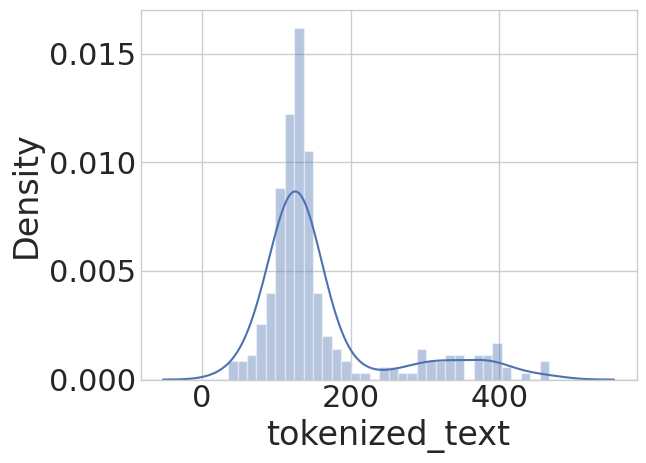

In [61]:
df_approach3['tokenized_text'] = df_approach3['tokenized'].apply(lambda x: " ".join(x))
sns.distplot(df_approach3['tokenized_text'].apply(lambda x: len(x.split())))

### Lemmatize sentiment

In [62]:
# pd.get_dummies(sentiment_spanish, prefix=None, dtype=bool)
# sentiment_spanish.columns = [column.lower() for column in sentiment_spanish.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_spanish.copy()
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_spanish.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [63]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
negative,1525
positive,332


### Tfidf

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    vectorizer = TfidfVectorizer(analyzer='word', vocabulary=sentiment_words)
    tfidf = vectorizer.fit_transform(docs)
    features = vectorizer.get_feature_names()
    
    return tfidf.toarray()

#### Text Dataframe

In [65]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf_org['negative']))
print(len(sentiment_tfidf_org['negative'][0]))

277
1525


/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [66]:
df_approach3.shape

(277, 7)

In [67]:
for sentiment in lemma_sentiments:
    df_approach3['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])
    
df_approach3

,statement,date,text,Index,tokenized,token_ids,tokenized_text,tfidf_negative,tfidf_positive
0,rpm_26_enero_2023.pdf,1/26/2023,Comunicado de Prensa Jueves 26 de enero de ...,0,"[política, monetaria, política, monetaria, con...","[1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 11, 1...",política monetaria política monetaria consejo ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,rpm_6_diciembre_2022.pdf,12/6/2022,Comunicado de Prensa Martes 6 de diciembre ...,1,"[martes, política, monetaria, política, moneta...","[178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, ...",martes política monetaria política monetaria c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,rpm_12_octubre_2022.pdf,10/12/2022,Comunicado de Prensa Miércoles 12 de octubr...,2,"[miércoles, política, monetaria, política, mon...","[235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 65, 9, 10, 1,...",miércoles política monetaria política monetari...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,rpm_06_septiembre_2022.pdf,9/6/2022,Comunicado de Prensa Martes 6 de septiembre...,3,"[martes, política, monetaria, política, moneta...","[178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...",martes política monetaria política monetaria c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,comunicado-rpm-13072022.pdf,7/13/2022,Comunicado de Prensa Miércoles 13 de julio ...,4,"[miércoles, política, monetaria, política, mon...","[235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...",miércoles política monetaria política monetari...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.3540249741154807, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
272,bcch_comunicado_094856_es.pdf,11/2/1998,COMUCDO2 de noviembre de 1998Consejo de Banco ...,272,"[banco, central, resolver, reducir, tasa, inst...","[4, 5, 1369, 412, 9, 1516, 247, 247, 2325, 103...",banco central resolver reducir tasa instancia ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33843104..."
273,bcch_comunicado_094857_es.pdf,10/13/1998,"antiago, 13 de octubre de 1998COMUCDOConsejo d...",273,"[antiago, banco, central, resolver, reducir, t...","[1751, 4, 5, 1369, 412, 9, 1516, 247, 247, 143...",antiago banco central resolver reducir tasa in...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
274,bcch_comunicado_094858_es.pdf,2/3/1998,"COMUCDOantiago, 3 de febrero de 1998. 1. l ...",274,"[comucdoantiago, consejo, banco, central, reso...","[2350, 3, 4, 5, 1369, 241, 25, 9, 1093, 1, 560...",comucdoantiago consejo banco central resolver ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
275,bcch_comunicado_094859_es.pdf,1/8/1998,"antiago, 8 de enero de 1998. COMUCDO1.2.3.4. ...",275,"[antiago, consejo, banco, central, resolver, a...","[1751, 3, 4, 5, 1369, 685, 1124, 293, 9, 10, 1...",antiago consejo banco central resolver adoptar...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Cosine Similarity

Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [68]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    #print(tfidf_matrix)
    return [cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0][0].tolist() for u, v in zip(tfidf_matrix, tfidf_matrix[1:])]

In [69]:
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values) 
    for sentiment_name, sentiment_values in sentiment_tfidf_org.items()}

print(len(cosine_similarities['negative']))

276


In [70]:
for sentiment in lemma_sentiments:
    # Add 0 to the first element as there is no comparison available to a previous value
    cosine_similarities[sentiment].insert(0, 0)
    df_approach3['cos_sim_' + sentiment] = cosine_similarities[sentiment]
    
df_approach3

,statement,date,text,Index,tokenized,token_ids,tokenized_text,tfidf_negative,tfidf_positive,cos_sim_negative,cos_sim_positive
0,rpm_26_enero_2023.pdf,1/26/2023,Comunicado de Prensa Jueves 26 de enero de ...,0,"[política, monetaria, política, monetaria, con...","[1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 11, 1...",política monetaria política monetaria consejo ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
1,rpm_6_diciembre_2022.pdf,12/6/2022,Comunicado de Prensa Martes 6 de diciembre ...,1,"[martes, política, monetaria, política, moneta...","[178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, ...",martes política monetaria política monetaria c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.570272,0.542998
2,rpm_12_octubre_2022.pdf,10/12/2022,Comunicado de Prensa Miércoles 12 de octubr...,2,"[miércoles, política, monetaria, política, mon...","[235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 65, 9, 10, 1,...",miércoles política monetaria política monetari...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.130865,0.167395
3,rpm_06_septiembre_2022.pdf,9/6/2022,Comunicado de Prensa Martes 6 de septiembre...,3,"[martes, política, monetaria, política, moneta...","[178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...",martes política monetaria política monetaria c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.283874,0.452494
4,comunicado-rpm-13072022.pdf,7/13/2022,Comunicado de Prensa Miércoles 13 de julio ...,4,"[miércoles, política, monetaria, política, mon...","[235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...",miércoles política monetaria política monetari...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.3540249741154807, 0.0, ...",0.517891,0.591581
...,...,...,...,...,...,...,...,...,...,...,...
272,bcch_comunicado_094856_es.pdf,11/2/1998,COMUCDO2 de noviembre de 1998Consejo de Banco ...,272,"[banco, central, resolver, reducir, tasa, inst...","[4, 5, 1369, 412, 9, 1516, 247, 247, 2325, 103...",banco central resolver reducir tasa instancia ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33843104...",0.275318,0.433190
273,bcch_comunicado_094857_es.pdf,10/13/1998,"antiago, 13 de octubre de 1998COMUCDOConsejo d...",273,"[antiago, banco, central, resolver, reducir, t...","[1751, 4, 5, 1369, 412, 9, 1516, 247, 247, 143...",antiago banco central resolver reducir tasa in...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.264189,0.199491
274,bcch_comunicado_094858_es.pdf,2/3/1998,"COMUCDOantiago, 3 de febrero de 1998. 1. l ...",274,"[comucdoantiago, consejo, banco, central, reso...","[2350, 3, 4, 5, 1369, 241, 25, 9, 1093, 1, 560...",comucdoantiago consejo banco central resolver ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.240027
275,bcch_comunicado_094859_es.pdf,1/8/1998,"antiago, 8 de enero de 1998. COMUCDO1.2.3.4. ...",275,"[antiago, consejo, banco, central, resolver, a...","[1751, 3, 4, 5, 1369, 685, 1124, 293, 9, 10, 1...",antiago consejo banco central resolver adoptar...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,1.000000


In [71]:
#df_text.to_csv(data_path+'/sentiment_peru_3.csv',index=False)

## Unify main features in df_merged

In [72]:
df_approach1_chile = df_approach1_chile[['Index','tone_LM']]
df_approach2_chile = df_approach2_chile[['Index','tone_GT']]
df_approach3 = df_approach3[['Index','tokenized','token_ids','tokenized_text','tfidf_negative','tfidf_positive','cos_sim_negative','cos_sim_positive']]

data_frames = [df_text_chile, df_approach1_chile, df_approach2_chile, df_approach3]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Index'], how='outer'), data_frames)

df_merged = df_merged.set_index(pd.to_datetime(df_merged['date'])).drop(columns=['date','Index'])

df_merged.reset_index(inplace=True)


df_merged.to_csv('text_sentiment_data_chile.csv', index_label=False, encoding='utf-8-sig')
df_merged.head()
#format="%Y-%m-%d"

,date,statement,text,tone_LM,tone_GT,tokenized,token_ids,tokenized_text,tfidf_negative,tfidf_positive,cos_sim_negative,cos_sim_positive
0,2023-01-26,rpm_26_enero_2023.pdf,Comunicado de Prensa Jueves 26 de enero de ...,0.000000,6.451613,"[política, monetaria, política, monetaria, con...","[1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 11, 1...",política monetaria política monetaria consejo ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
1,2022-12-06,rpm_6_diciembre_2022.pdf,Comunicado de Prensa Martes 6 de diciembre ...,-0.982318,0.000000,"[martes, política, monetaria, política, moneta...","[178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, ...",martes política monetaria política monetaria c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.570272,0.542998
2,2022-10-12,rpm_12_octubre_2022.pdf,Comunicado de Prensa Miércoles 12 de octubr...,-0.189394,20.000000,"[miércoles, política, monetaria, política, mon...","[235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 65, 9, 10, 1,...",miércoles política monetaria política monetari...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.130865,0.167395
3,2022-09-06,rpm_06_septiembre_2022.pdf,Comunicado de Prensa Martes 6 de septiembre...,0.167224,19.444444,"[martes, política, monetaria, política, moneta...","[178, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...",martes política monetaria política monetaria c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.283874,0.452494
4,2022-07-13,comunicado-rpm-13072022.pdf,Comunicado de Prensa Miércoles 13 de julio ...,-1.068702,11.428571,"[miércoles, política, monetaria, política, mon...","[235, 1, 2, 1, 2, 3, 4, 5, 6, 7, 308, 9, 10, 1...",miércoles política monetaria política monetari...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.3540249741154807, 0.0, ...",0.517891,0.591581
